# Only Ear/Face Training

In [1]:
import os
import numpy as np
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
tf.__version__

'2.3.0'

In [4]:
ROOT_DIR = os.path.abspath("../../")
#DS_DIR = os.path.join(ROOT_DIR, "Datasets", "VGGFaceEar", "face_augmented")
DS_DIR = os.path.join(ROOT_DIR, "Datasets", "VGGFaceEar", "ear_augmented")
DS_train_DIR = os.path.join(DS_DIR, "train")
DS_val_DIR = os.path.join(DS_DIR, "val")
DS_test_DIR = os.path.join(DS_DIR, "test")
img_width, img_height = 224, 224
batch_size_ = 32

In [5]:
trdata = ImageDataGenerator(
    rescale=1./255.)
traindata = trdata.flow_from_directory(
    directory=DS_train_DIR,
    target_size=(img_width,img_height),
    batch_size=batch_size_,
    shuffle=True,
    class_mode='sparse')

vldata = ImageDataGenerator(
    rescale=1./255.)
valdata = vldata.flow_from_directory(
    directory=DS_val_DIR, 
    target_size=(img_width,img_height),
    batch_size=batch_size_,
    shuffle=True,
    class_mode='sparse')

tsdata = ImageDataGenerator(
    rescale=1./255.)
testdata = tsdata.flow_from_directory(
    directory=DS_test_DIR, 
    target_size=(img_width,img_height),
    batch_size=1,
    shuffle=False,
    class_mode='sparse',
)

Found 14868 images belonging to 25 classes.
Found 4032 images belonging to 25 classes.
Found 192 images belonging to 25 classes.


In [6]:
set_size = 25   #clases

### VGGFace (from DeepFace)

In [7]:
#!pip install gdown

In [8]:
import tensorflow as tf
import os
from pathlib import Path
import gdown

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

In [9]:
tf.__version__

'2.3.0'

In [10]:
##--> Cortesia de DeepFace
def baseModel():
	model = Sequential()
	model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
	model.add(Convolution2D(64, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(128, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(128, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(Convolution2D(4096, (7, 7), activation='relu'))
	model.add(Dropout(0.5))
	model.add(Convolution2D(4096, (1, 1), activation='relu'))
	model.add(Dropout(0.5))
	model.add(Convolution2D(2622, (1, 1)))
	model.add(Flatten())
	model.add(Activation('softmax'))
	
	return model

def loadModel(url = 'https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo'):
	
	model = baseModel()
	
	#-----------------------------------
	
	home = str(Path.home())
	output = home+'/.deepface/weights/vgg_face_weights.h5'
	
	if os.path.isfile(output) != True:
		print("vgg_face_weights.h5 will be downloaded...")		
		gdown.download(url, output, quiet=False)
	
	#-----------------------------------
	
	try:
		model.load_weights(output)
	except Exception as err:
		print(str(err))
		print("Pre-trained weight could not be loaded.")
		print("You might try to download the pre-trained weights from the url ", url, " and copy it to the ", output)
	
	#-----------------------------------
	
	vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
	
	return vgg_face_descriptor

In [11]:
model_vggface = loadModel()

In [13]:
#model_vggface.summary()

In [12]:
for layer in model_vggface.layers[:-6]:
    layer.trainable = False

In [13]:
## --> Replace 
out = (Dense(set_size, activation='softmax', name='predictions'))(model_vggface.output)

final_model = Model(inputs=[model_vggface.input], outputs=[out])
#final_model.summary()

### Compile model

In [14]:
#final_model.compile(optimizer=Adam(lr=0.001), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_1.h5--> 58%
final_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])  #vgg16_2.h5--> 99%  #with 2 dropout layers
#model_face.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 99.37%  #without dropout layers
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 98.75%
#model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 55%
#model_face.compile(optimizer=RMSprop(lr=0.1), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_3.h5--> 55%

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "TrainedModels/vggEar_25class_aug.h5", 
    monitor='sparse_categorical_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto')

early = EarlyStopping(
    monitor='sparse_categorical_accuracy', 
    min_delta=0, 
    patience=3,
    #if it doesn’t see any rise in validation accuracy in 25,  the model will stop 
    verbose=1, 
    mode='auto')

hist = final_model.fit(
    x=traindata, 
    #steps_per_epoch=traindata.samples//batch_size_,
    validation_data= valdata, 
    epochs=10,
    callbacks=[checkpoint,early])

Epoch 1/10
465/465 [==============================] - ETA: 0s - loss: 3.2156 - sparse_categorical_accuracy: 0.0712
Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.07116, saving model to TrainedModels\vggEar_25class_aug.h5
465/465 [==============================] - 135s 291ms/step - loss: 3.2156 - sparse_categorical_accuracy: 0.0712 - val_loss: 3.2129 - val_sparse_categorical_accuracy: 0.0454
Epoch 2/10
465/465 [==============================] - ETA: 0s - loss: 3.2027 - sparse_categorical_accuracy: 0.0989
Epoch 00002: sparse_categorical_accuracy improved from 0.07116 to 0.09887, saving model to TrainedModels\vggEar_25class_aug.h5
465/465 [==============================] - 132s 284ms/step - loss: 3.2027 - sparse_categorical_accuracy: 0.0989 - val_loss: 3.1984 - val_sparse_categorical_accuracy: 0.1086
Epoch 3/10
465/465 [==============================] - ETA: 0s - loss: 3.1716 - sparse_categorical_accuracy: 0.1460
Epoch 00003: sparse_categorical_accuracy improved from 0.0

In [ ]:
#final_model.save("vggface_.h5")

### Evaluating before Fusion

#### FACE

In [20]:
results = final_model.evaluate(valdata)
print("test loss, test acc:", results)

126/126 [==============================] - 20s 157ms/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9710
test loss, test acc: [0.08311619609594345, 0.9709821343421936]


In [19]:
results = final_model.evaluate(testdata)
print("test loss, test acc:", results)

192/192 [==============================] - 13s 68ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.9844
test loss, test acc: [0.12812824547290802, 0.984375]


#### EAR

In [16]:
results = final_model.evaluate(valdata)
print("test loss, test acc:", results)

126/126 [==============================] - 19s 154ms/step - loss: 1.6101 - sparse_categorical_accuracy: 0.5737
test loss, test acc: [1.6101456880569458, 0.5736607313156128]


In [17]:
results = final_model.evaluate(testdata)
print("test loss, test acc:", results)

192/192 [==============================] - 13s 68ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.7031
test loss, test acc: [1.25001060962677, 0.703125]


# Fuse training

In [1]:
import os
import numpy as np
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
tf.__version__

'2.3.0'

### Get Data

In [4]:
ROOT_DIR = os.path.abspath("../../")
DS_DIR_EAR = os.path.join(ROOT_DIR, "Datasets", "VGGFaceEar", "ear_25class")
DS_DIR_FACE = os.path.join(ROOT_DIR, "Datasets", "VGGFaceEar", "face_25class")
img_width, img_height = 224, 224
batch_size_ = 32

In [5]:
def generate_generator_multiple(generator,dir1, dir2, batch_size,img_height,img_width):
    genX1 = generator.flow_from_directory(dir1,
                              target_size = (img_height,img_width),
                              class_mode = 'sparse',
                              batch_size = batch_size,
                              shuffle=False)
    
    genX2 = generator.flow_from_directory(dir2,
                              target_size = (img_height, img_width),
                              class_mode = 'sparse',
                              batch_size = batch_size, 
                              shuffle=False)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X2i[1]  #


In [6]:
trdata = ImageDataGenerator(
    rescale=1./255.)
traindata_face_ear = generate_generator_multiple(
    generator = trdata,
    dir1 = os.path.join(DS_DIR_FACE, "train"),
    dir2 = os.path.join(DS_DIR_EAR, "train"),
    batch_size = batch_size_,
    img_height = img_height,
    img_width = img_width,
)

vldata = ImageDataGenerator(
    rescale=1./255.)
valdata_face_ear = generate_generator_multiple(
    generator = vldata,
    dir1 = os.path.join(DS_DIR_FACE, "val"),
    dir2 = os.path.join(DS_DIR_EAR, "val"),
    batch_size = batch_size_,
    img_height = img_height,
    img_width = img_width,
)

tsdata = ImageDataGenerator(
    rescale=1./255.)
testdata_face_ear = generate_generator_multiple(
    generator = tsdata,
    dir1 = os.path.join(DS_DIR_FACE, "test"),
    dir2 = os.path.join(DS_DIR_EAR, "test"),
    batch_size = batch_size_,
    img_height = img_height,
    img_width = img_width,
)

In [7]:
a = next(traindata_face_ear)
b = next(valdata_face_ear)
c = next(testdata_face_ear)


Found 708 images belonging to 25 classes.
Found 708 images belonging to 25 classes.
Found 192 images belonging to 25 classes.
Found 192 images belonging to 25 classes.
Found 192 images belonging to 25 classes.
Found 192 images belonging to 25 classes.


In [8]:
set_size = 25   #clases

### Show samples

In [10]:
import imgaug as ia
ia.seed(1)
x = next(traindata_face_ear)

ModuleNotFoundError: No module named 'imgaug'

In [10]:
x[0][0].shape, x[0][1].shape, x[1].shape

((32, 224, 224, 3), (32, 224, 224, 3), (32,))

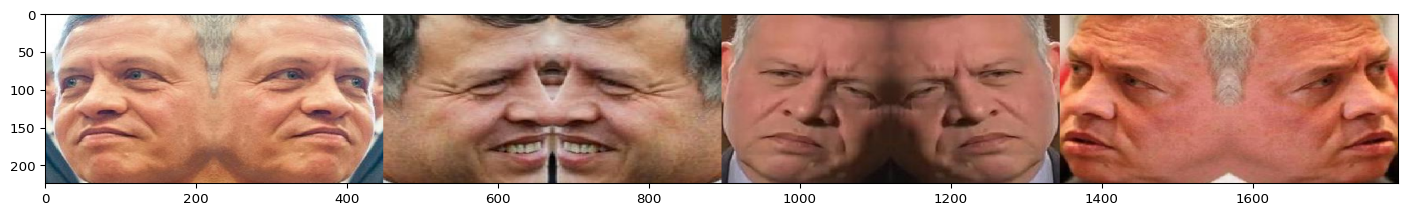

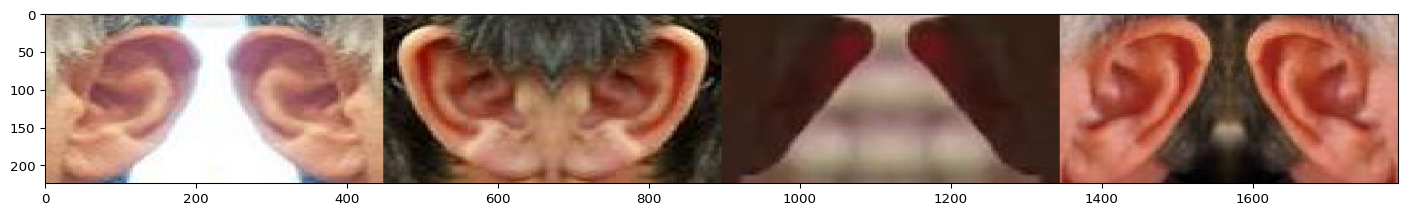

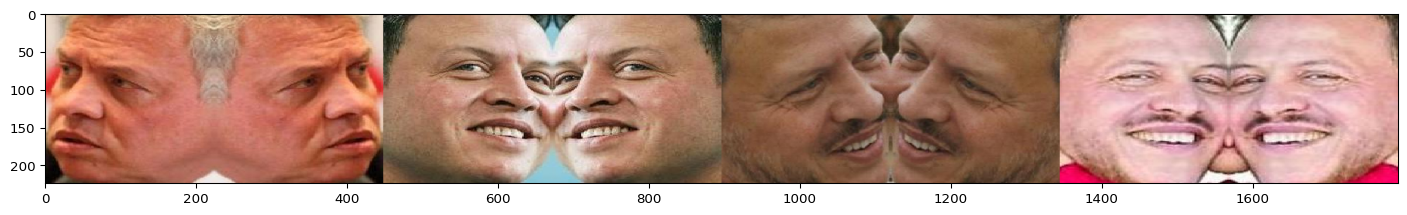

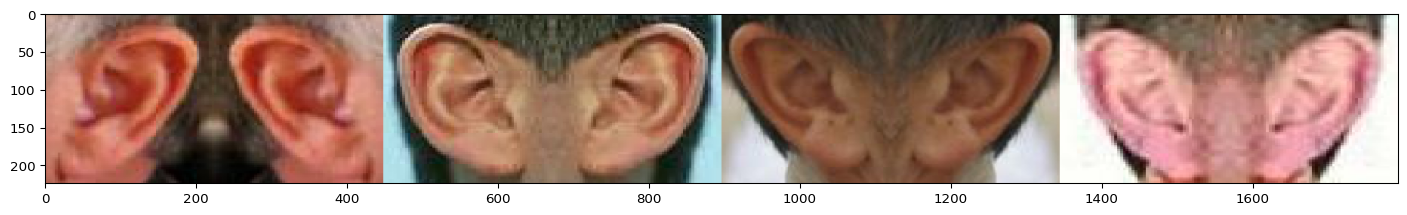

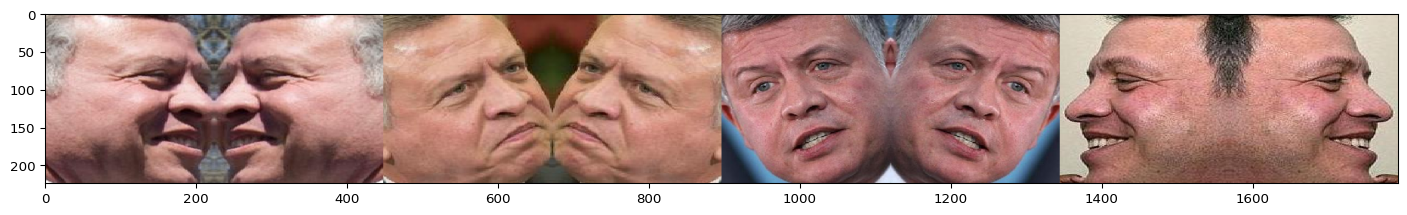

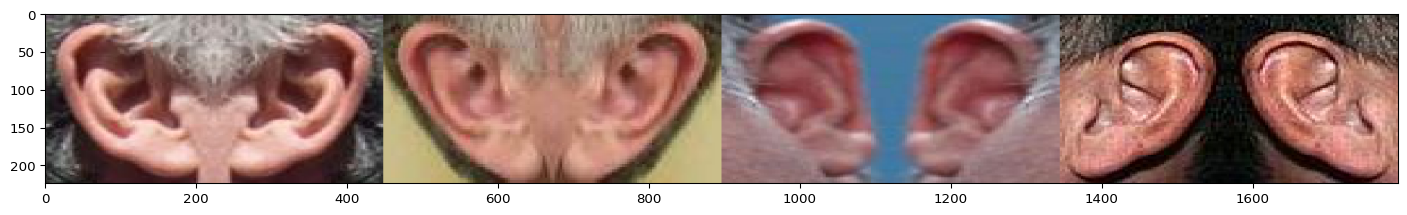

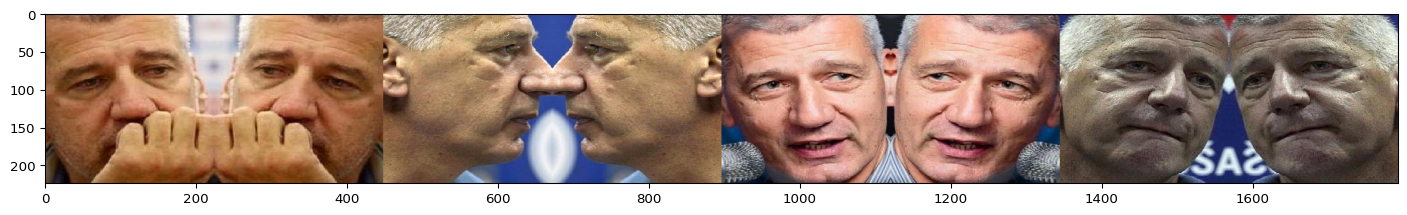

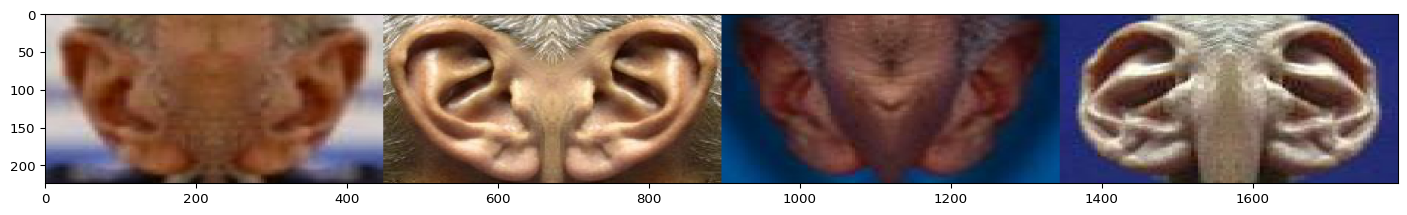

In [11]:
for i in range (4):
    ia.imshow(np.hstack(x[0][0][i*8:i*8+8]))
    ia.imshow(np.hstack(x[0][1][i*8:i*8+8]))

## Set the model

In [9]:
model_face = load_model("TrainedModels/vggFace_25class_aug.h5")

In [10]:
for layer in model_face.layers:
    layer.trainable = False
    layer._name = layer._name + "_cnn_face"

In [11]:
out1 = model_face.layers[-2].output
out1.shape

TensorShape([None, 2622])

In [12]:
model_ear = load_model("TrainedModels/vggEar_25class_aug.h5")

In [13]:
for layer in model_ear.layers:
    layer.trainable = False
    layer._name = layer._name + "_cnn_ear"

In [14]:
out2 = model_ear.layers[-2].output
out2.shape

TensorShape([None, 2622])

In [15]:
con = Concatenate()([out1, out2])

out = Flatten()(con)
out = (Dense(2622, activation='relu', name='fc1'))(out)
out = (Dropout(0.3))(out)
out = (Dense(2622, activation='relu', name='fc2'))(out)
out = (Dropout(0.3))(out)
out = (Dense(set_size, activation='softmax', name='predictions'))(out)

model = Model(inputs=[model_face.input, model_ear.input], outputs=[out])


In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
zero_padding2d_input_cnn_face ( [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_input_cnn_ear (I [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_cnn_face (ZeroPa (None, 226, 226, 3)  0           zero_padding2d_input_cnn_face[0][
__________________________________________________________________________________________________
zero_padding2d_cnn_ear (ZeroPad (None, 226, 226, 3)  0           zero_padding2d_input_cnn_ear[0][0
_______________________________________________________________________________________

In [17]:
#model.compile(optimizer=Adam(lr=0.1), loss=keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])  #vgg16_1.h5--> 58%
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy'])  #vgg16_2.h5--> 99%  #with 2 dropout layers
#model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 99.37%  #without dropout layers
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 98.75%
#model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])  #vgg16_2.h5--> 55%
#model.compile(optimizer=RMSprop(lr=0.1), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])  #vgg16_3.h5--> 55%

In [18]:
#model.fit([traindata_face, traindata_ear], [valdata_face, valdata_ear], epochs=10)

In [20]:
tensorboardcb = keras.callbacks.TensorBoard(log_dir='Tensorboard_logs', histogram_freq=0, write_graph=True)
model.fit(
    traindata_face_ear,
    epochs=15,
    steps_per_epoch=708//32,
    validation_data=valdata_face_ear,
    validation_steps = 192//32,
    callbacks=[tensorboardcb])

Epoch 1/15
22/22 [==============================] - 10s 442ms/step - loss: 0.1577 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.1242 - val_sparse_categorical_accuracy: 0.9844
Epoch 2/15
22/22 [==============================] - 9s 419ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.1150 - val_sparse_categorical_accuracy: 0.9896
Epoch 3/15
22/22 [==============================] - 9s 418ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.1089 - val_sparse_categorical_accuracy: 0.9844
Epoch 4/15
22/22 [==============================] - 9s 424ms/step - loss: 0.1106 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0949 - val_sparse_categorical_accuracy: 0.9896
Epoch 5/15
22/22 [==============================] - 9s 416ms/step - loss: 0.0946 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0919 - val_sparse_categorical_accuracy: 0.9896
Epoch 6/15
22/22 [==============================] - 9s 416ms/step - loss: 0.0944 - sparse_categoric

In [23]:
model.save("TrainedModels/vggFaceEar_25class_aug.h5")

In [23]:
tensorboardcb = keras.callbacks.TensorBoard(log_dir='Tensorboard_logs', histogram_freq=0, write_graph=True)
model.fit(
    traindata_face_ear,
    epochs=10,
    steps_per_epoch=708//32,
    validation_data=valdata_face_ear,
    validation_steps = 192//32,
    callbacks=[tensorboardcb])

Epoch 1/10
22/22 [==============================] - 8s 385ms/step - loss: 0.1623 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.1185 - val_sparse_categorical_accuracy: 0.9844
Epoch 2/10
22/22 [==============================] - 8s 383ms/step - loss: 0.1539 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.1207 - val_sparse_categorical_accuracy: 0.9792
Epoch 3/10
22/22 [==============================] - 8s 381ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0986 - val_sparse_categorical_accuracy: 0.9896
Epoch 4/10
22/22 [==============================] - 8s 382ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0943 - val_sparse_categorical_accuracy: 0.9792
Epoch 5/10
22/22 [==============================] - 8s 383ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.0891 - val_sparse_categorical_accuracy: 0.9896
Epoch 6/10
22/22 [==============================] - 8s 383ms/step - loss: 0.0936 - sparse_categorica

#### Fusion

In [24]:
results = model.evaluate(valdata_face_ear, steps= 192)
print("test loss, test acc:", results)

192/192 [==============================] - 60s 311ms/step - loss: 0.0804 - sparse_categorical_accuracy: 0.9844
test loss, test acc: [0.08037057518959045, 0.984375]


In [21]:
results = model.evaluate(valdata_face_ear, steps= 192)
print("test loss, test acc:", results)

192/192 [==============================] - 68s 356ms/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9844
test loss, test acc: [0.07528466731309891, 0.984375]


In [25]:
results = model.evaluate(testdata_face_ear, steps= 192)
print("test loss, test acc:", results)

192/192 [==============================] - 60s 312ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9740
test loss, test acc: [0.10772854089736938, 0.9739583134651184]


In [22]:
results = model.evaluate(testdata_face_ear, steps= 192)
print("test loss, test acc:", results)

192/192 [==============================] - 68s 356ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9792
test loss, test acc: [0.09370279312133789, 0.9791666865348816]


In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "vgg16_Face_Adam_100Epoch.h5", 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto')

early = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=25,
    #if it doesn’t see any rise in validation accuracy in 25,  the model will stop 
    verbose=1, 
    mode='auto')

hist = model.fit(
    x=[traindata_face, traindata_ear], 
    validation_data = ([valdata_face, valdata_ear]),
    epochs=10,
    callbacks=[checkpoint,early])

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>"}), <class 'NoneType'>